In [2]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import math

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from scipy.optimize import optimize
from collections import defaultdict
from itertools import izip_longest
from functools import partial

Function to Optimize for: func_z

def f(X, Y):
    return (X**2 - 10 * np.cos(2 * 3.14 * X)) + \
  (Y**2 - 10 * np.cos(2 * 3.14 * Y)) + 20

In [46]:
def sphere(*args):
    k = 0
    for i in args: k += i**2
    return k
logSpace = np.logspace(-5, 2, 35)
logNorm = LogNorm()

def rastrigin(*args):
    A = 10
    return A + sum([(i**2 - A * np.cos(2 * math.pi * i)) for i in args])

def styblinskiTang(*args):
    return sum([(i**4 - 16 * i**2 + 5 * i) for i in args])
stSpace = np.linspace(-200, 100, 35)
stNorm = None

# f = rastrigin
# name = "rastrigin"
# fspace = logSpace
# fnorm = logNorm


In [3]:
# x_lims = [xmin, xmax, xstep] as a list
def get_mesh_for_plot(f, x_lims, y_lims):
    xmin, xmax, xstep = tuple(x_lims)
    ymin, ymax, ystep = tuple(y_lims)
    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = f(x, y)
    return x, y, z


Initialized Parameters

### 3-D Plot Function

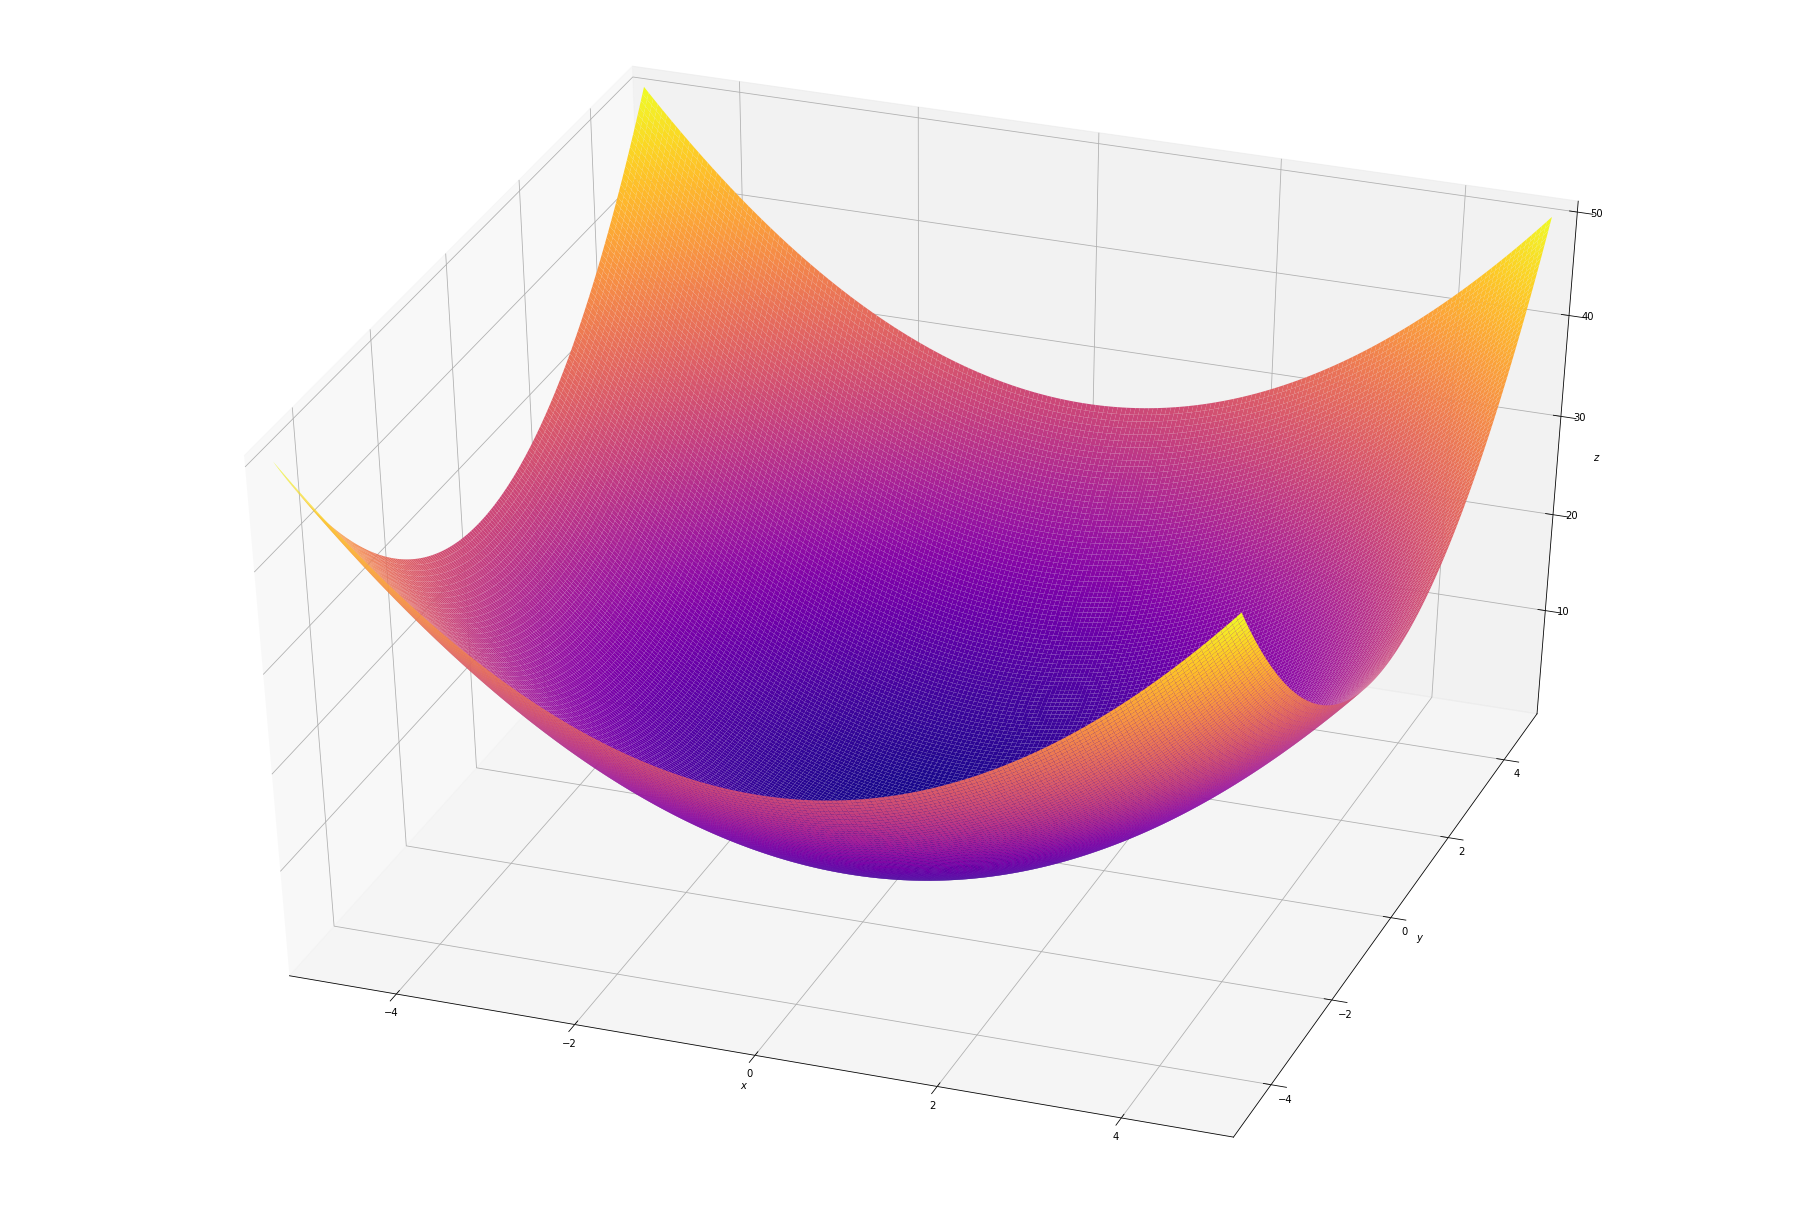

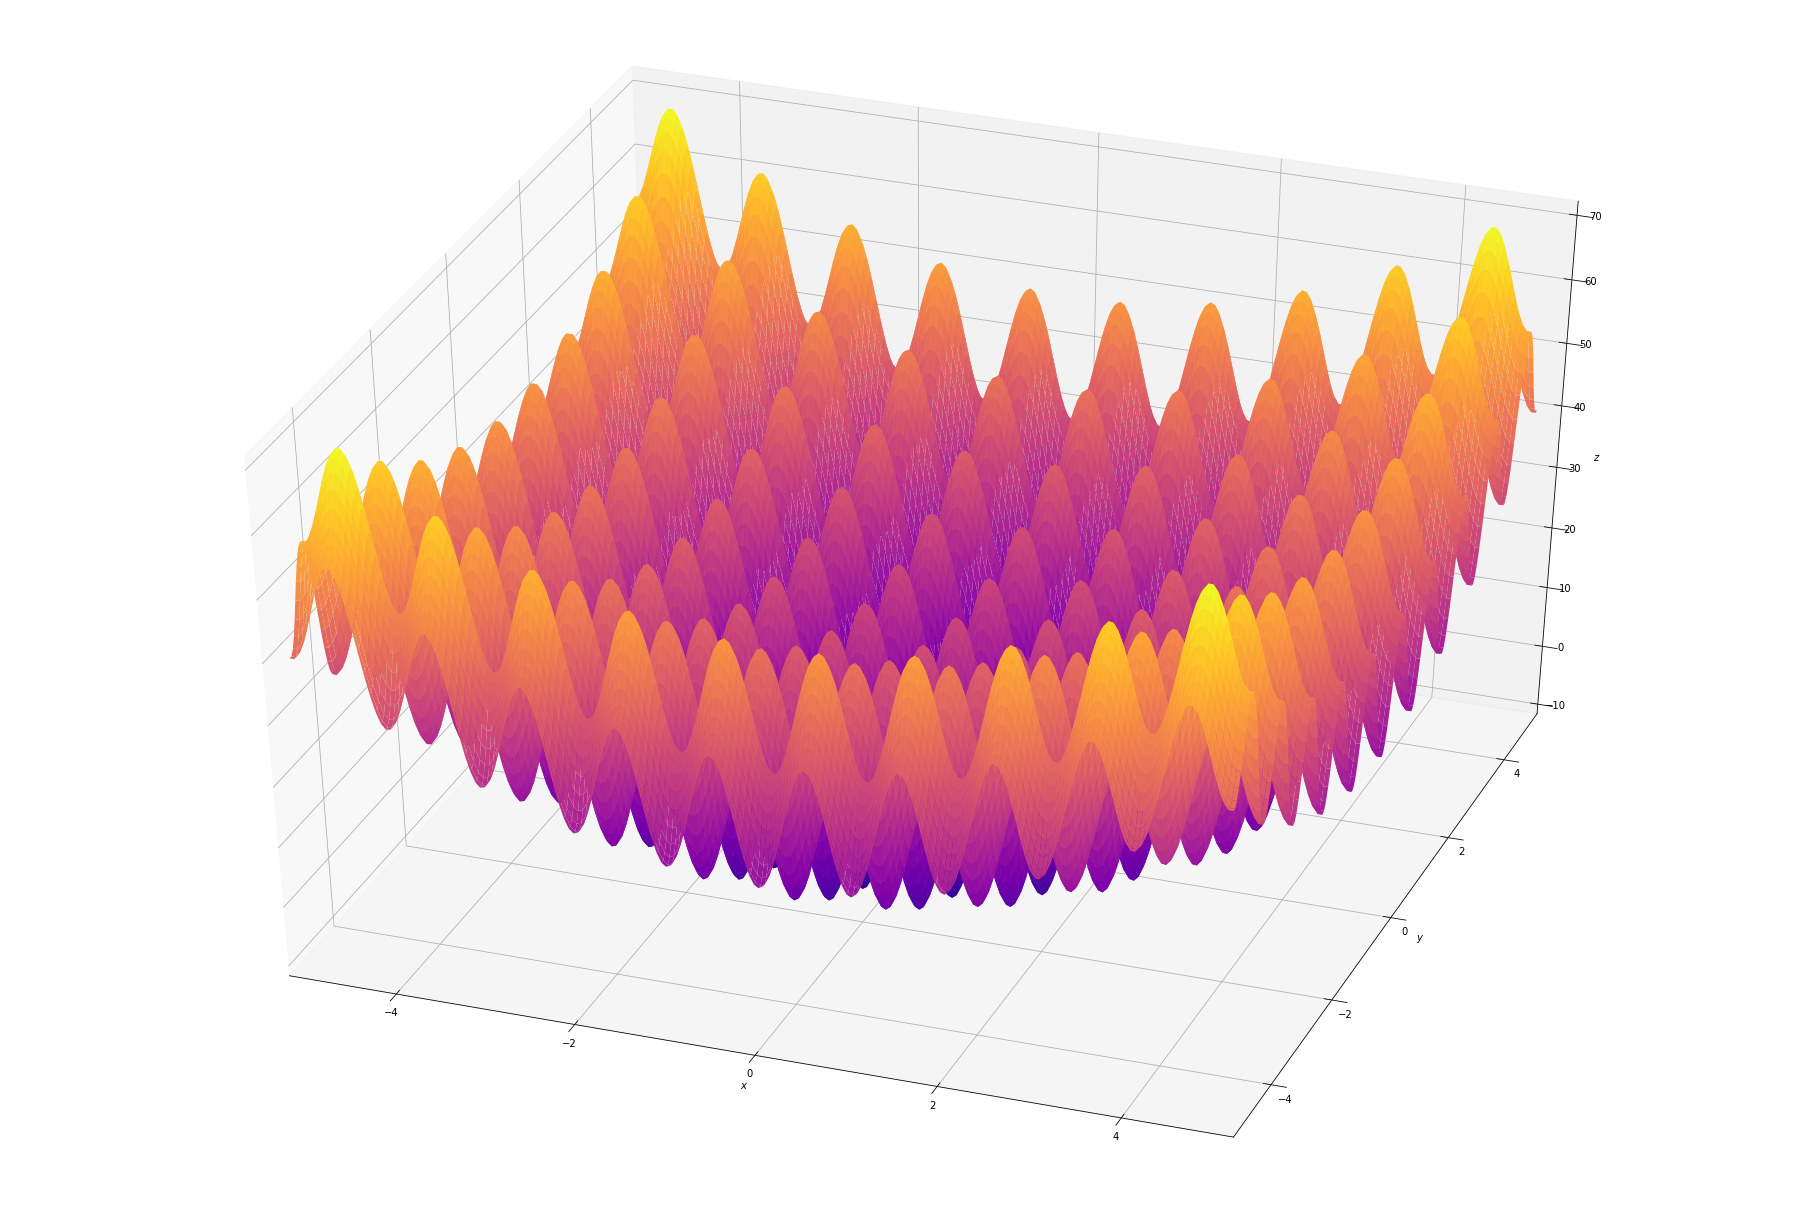

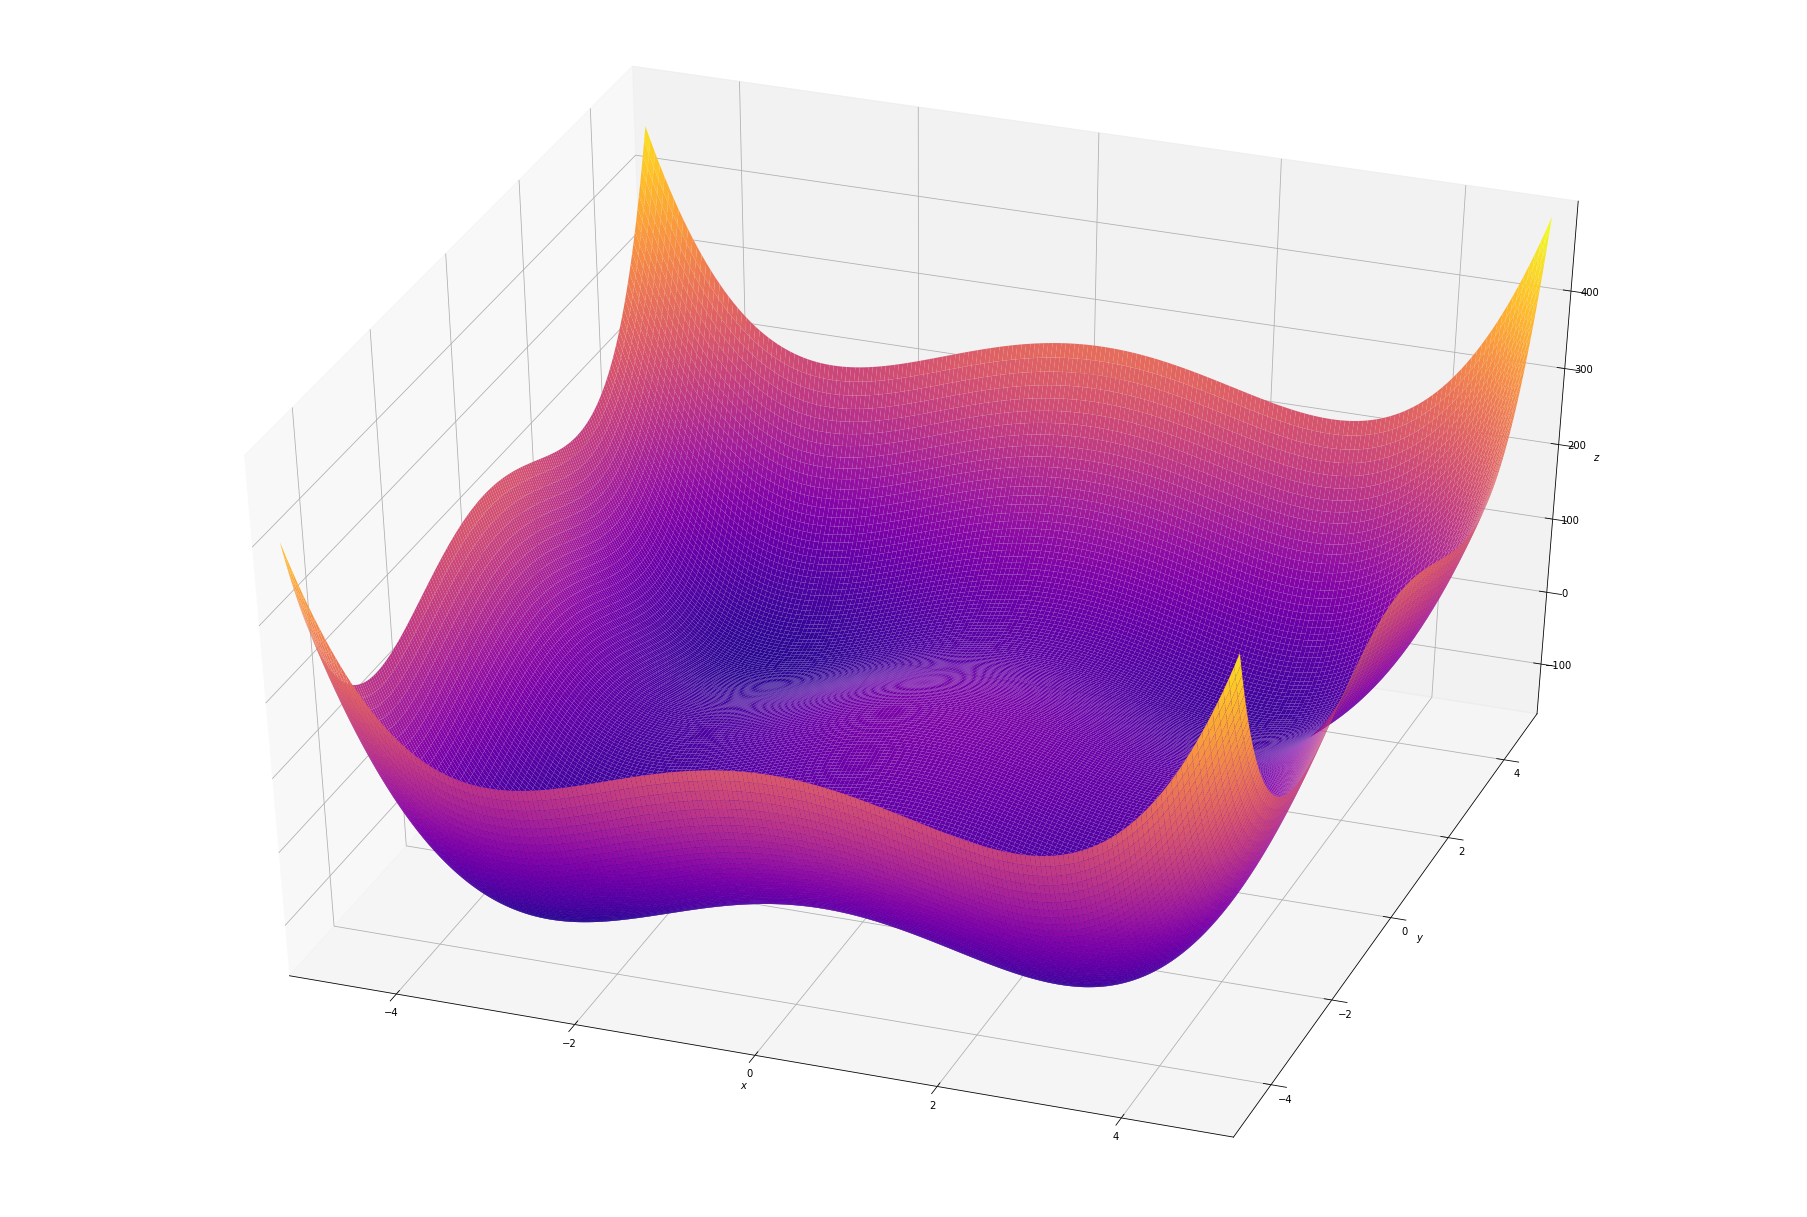

In [73]:
def three_dimentional_plot(f, x_lims, y_lims):
    x, y, z = get_mesh_for_plot(f, x_lims, y_lims)
    xmin, xmax, xstep = tuple(x_lims)
    ymin, ymax, ystep = tuple(y_lims)
    
    fig = plt.figure(figsize=(32, 22))
    ax = plt.axes(projection='3d', elev=40, azim=-70)

    ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=plt.cm.plasma, linewidth=1, antialiased=True)
    # ax.plot(*minima_, f(*minima), 'r*', markersize=20, color="r")

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show()

three_dimentional_plot(sphere, [-5, 5, 0.05], [-5, 5, 0.05])
three_dimentional_plot(rastrigin, [-5, 5, 0.05], [-5, 5, 0.05])
three_dimentional_plot(styblinskiTang, [-5, 5, 0.05], [-5, 5, 0.05])

### Plot Contour Map

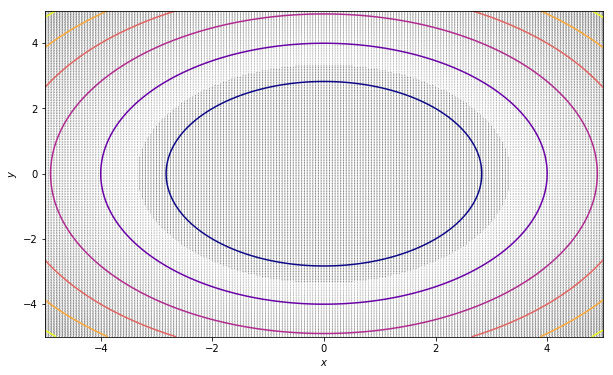

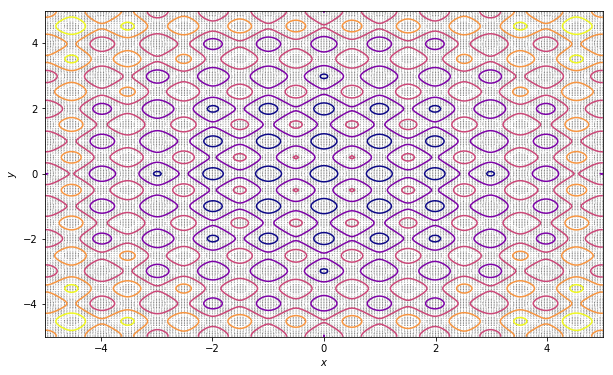

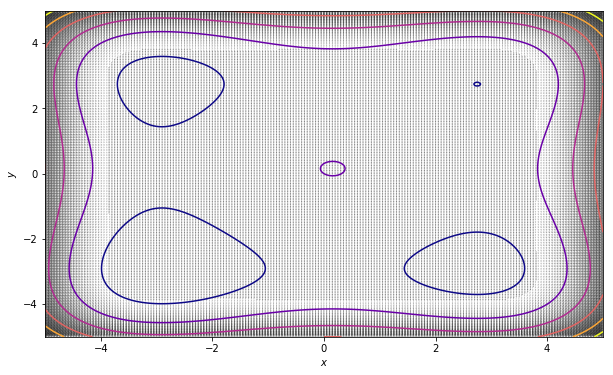

In [74]:
def contour_plot(f, x_lims, y_lims):
    x, y, z = get_mesh_for_plot(f, x_lims, y_lims)
    xmin, xmax, xstep = tuple(x_lims)
    ymin, ymax, ystep = tuple(y_lims)
    
    dz_dx = elementwise_grad(f, argnum=0)(x, y)
    dz_dy = elementwise_grad(f, argnum=1)(x, y)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, cmap=plt.cm.plasma) # took out levels=fspace, norm=fnorm, 
    ax.quiver(x, y, x - dz_dx, y - dz_dy, alpha=.5)
    #ax.plot(*minima_, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show()
    
contour_plot(sphere, [-5, 5, 0.05], [-5, 5, 0.05])
contour_plot(rastrigin, [-5, 5, 0.05], [-5, 5, 0.05])
contour_plot(styblinskiTang, [-5, 5, 0.05], [-5, 5, 0.05])

### Optimize

In [75]:
# func = value_and_grad(lambda args: f(*args))
# x0 = np.array([3., 4.])
# res = minimize(func, x0=x0, method='Newton-CG', jac=True, tol=1e-20)
# print res

# def make_minimize_cb(path=[]):  
#     def minimize_cb(xk):
#         # note that we make a deep copy of xk
#         path.append(np.copy(xk))
#     return minimize_cb

# path_ = [x0]
# minimize(func, x0=x0, method='Newton-CG',
#                jac=True, tol=1e-20, callback=make_minimize_cb(path_))
# path = np.array(path_).T
# path.shape
# print path

In [76]:
def sphere2(x):
    return sum([i**2 for i in x])

def rastrigin2(x):
    A = 10
    return A + sum([(i**2 - A * np.cos(2 * math.pi * i)) for i in x])

def styblinskiTang2(x):
    return sum([(i**4 - 16 * i**2 + 5 * i) for i in x])

class Optimizer:
    
    def __init__(self, f, eta, grad_step = 0.1):
        self.f = f
        self.eta = eta
        self.grad_step = grad_step
        
    def update(self, params, f):

        delta_params = self.eta * optimize.approx_fprime(params, f, self.grad_step)
        #print "gradient: {0}".format(delta_params)
        params = [p - dp for p, dp in zip(params, delta_params)]

        return params

    def update_momentum(self, params, f, momentum, prev_update_vector):

        update_vector = momentum * prev_update_vector + self.eta * optimize.approx_fprime(params, f, self.grad_step)
        #print "gradient: {0}".format(optimize.approx_fprime(params, f, self.eta))
        params = [p - dp for p, dp in zip(params, update_vector)]

        return (params, update_vector)
    
    def update_accel(self, params, f, momentum, prev_update_vector):

        update_vector = momentum * prev_update_vector + self.eta * optimize.approx_fprime(params - prev_update_vector, f, self.grad_step)
        #print "gradient: {0}".format(optimize.approx_fprime(params, f, self.eta))
        params = [p - dp for p, dp in zip(params, update_vector)]

        return (params, update_vector)
    
    def get_path_gradient_descent(self, param, count):
        path = [param]
        for i in range(count):
            param = self.update(param, self.f)
            path.append(param)

        path = np.array(path).T
        return path
    
    def get_path_momentum(self, param, count, momentum=0.9):
        path = [param]
        update_vector = 0
        for i in range(count):
            (param, update_vector) = self.update_momentum(param, self.f, momentum, update_vector)
            path.append(param)

        path = np.array(path).T
        return path
    
    def get_path_acceleration(self, param, count, momentum=0.9):
        path = [param]
        update_vector = 0
        for i in range(count):
            (param, update_vector) = self.update_accel(param, self.f, momentum, update_vector)
            path.append(param)

        path = np.array(path).T
        return path

def optimization_plot(f, x_lims, y_lims, path):
    x, y, z = get_mesh_for_plot(f, x_lims, y_lims)
    xmin, xmax, xstep = tuple(x_lims)
    ymin, ymax, ystep = tuple(y_lims)
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, cmap=plt.cm.plasma) # took out levels=fspace, norm=fnorm, 
    ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k', width=0.005)
    #ax.plot(minima_, 'r*', markersize=10)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show()
    
def animate_plot(f, x_lims, y_lims, path):
    x, y, z = get_mesh_for_plot(f, x_lims, y_lims)
    xmin, xmax, xstep = tuple(x_lims)
    ymin, ymax, ystep = tuple(y_lims)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, cmap=plt.cm.plasma) # took out levels=fspace, norm=fnorm, 
    # ax.plot(minima_, 'r*', markersize=18)

    line, = ax.plot([], [], 'b', label='Trajectory of Theta', lw=2)
    point, = ax.plot([], [], 'bo')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    ax.legend(loc='upper left')

    def init():
        line.set_data([], [])
        point.set_data([], [])
        return line, point

    def animate(i):
        #line.set_data(*path[::,:i]) # comment out to not show the trajectory
        point.set_data(*path[::,i-1:i])
        return line, point

    return animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=path.shape[1], interval=100, 
                                   repeat_delay=5, blit=True)


## Complete Drawing Here

[[ 1.          0.979       0.93952     0.8841976   0.81572349  0.73678232
   0.64999962  0.5578952   0.46284331  0.36703975  0.27247575  0.18091863
   0.09389886  0.01270308 -0.06162718 -0.12829187 -0.18672425 -0.23657891
  -0.27771653 -0.31018605 -0.33420491 -0.35013777 -0.3584746  -0.35980825
  -0.35481237 -0.34421983 -0.32880215 -0.30935019 -0.28665643 -0.26149891
  -0.23462717 -0.20675006 -0.17852565 -0.15055318 -0.12336689 -0.09743189
  -0.07314175 -0.05081779 -0.03070987 -0.01299855  0.00220161  0.01483773
   0.02491348  0.03248338  0.03764663  0.04054062  0.04133439  0.0402221
   0.0374166   0.03314332  0.0276345   0.02112387  0.01384183  0.00601115
  -0.00215668 -0.0104646  -0.01873243 -0.02679883 -0.03452261 -0.04178356
  -0.04848275 -0.05454236 -0.05990516 -0.06453358 -0.06840849 -0.07152774
  -0.0739045  -0.0755655  -0.07654909 -0.07690334 -0.0766841  -0.0759531
  -0.07477614 -0.07322135 -0.07135761 -0.0692531  -0.06697397 -0.06458328
  -0.06213999 -0.05969823 -0.05730668 -0

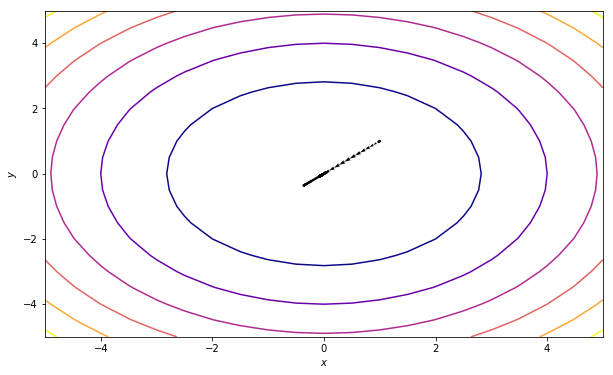

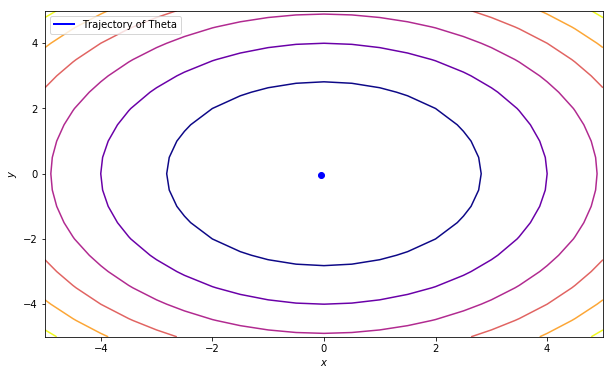

In [88]:
opt = Optimizer(sphere2, 0.01)
path = opt.get_path_momentum(np.array([1., 1.]), 100, momentum=0.9)

print path
print "final opt: {0},{1}".format(path[0][-1],path[1][-1])

x_lim = [-5, 5, 0.5]
y_lim = [-5, 5, 0.5]

optimization_plot(sphere, x_lim, y_lim, path)

anim = animate_plot(sphere, x_lim, y_lim, path)
HTML(anim.to_html5_video())

### Animating Optimization

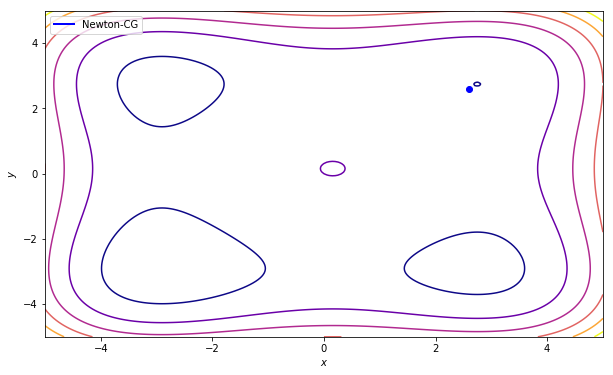

In [137]:
HTML(anim.to_html5_video())